In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

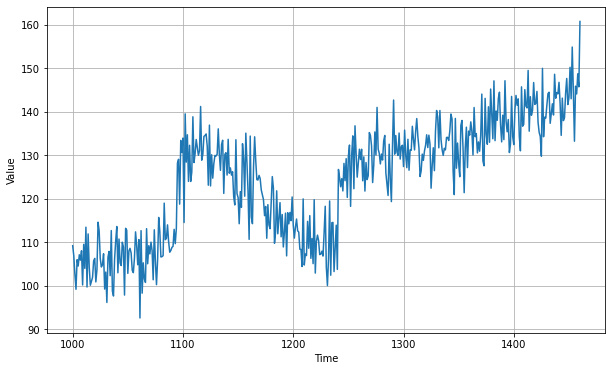

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)


Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 644.7889
Epoch 2/100
31/31 [==============================] - 0s 919us/step - loss: 69.2993
Epoch 3/100
31/31 [==============================] - 0s 894us/step - loss: 47.1602
Epoch 4/100
31/31 [==============================] - 0s 870us/step - loss: 43.5636
Epoch 5/100
31/31 [==============================] - 0s 893us/step - loss: 43.1843
Epoch 6/100
31/31 [==============================] - 0s 878us/step - loss: 44.6495
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 43.1568
Epoch 8/100
31/31 [==============================] - 0s 974us/step - loss: 43.2356
Epoch 9/100
31/31 [==============================] - 0s 891us/step - loss: 42.7619
Epoch 10/100
31/31 [==============================] - 0s 889us/step - loss: 42.4399
Epoch 11/100
31/31 [==============================] - 0s 958us/step - loss: 42.6194
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 41.8576
Epoch 

31/31 [==============================] - 0s 1ms/step - loss: 35.7411
Epoch 100/100
31/31 [==============================] - 0s 1ms/step - loss: 35.5652


In [6]:
model.input_shape

(None, 20)

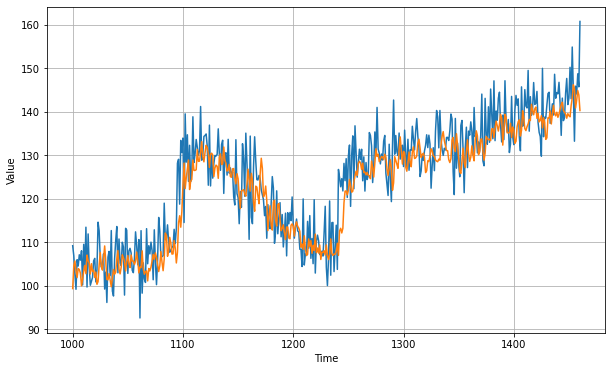

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis],verbose = 0))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0116076

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 15791.6943 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 966us/step - loss: 7329.4448 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 946us/step - loss: 3020.2346 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 955us/step - loss: 1077.9395 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 307.1891 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 705us/step - loss: 114.3915 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 712us/step - loss: 84.1682 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 712us/step - loss: 82.1520 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 724us/step - loss: 81.8397 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 712us/step - loss: 81.6748 - lr: 2.8

31/31 [==============================] - 0s 1ms/step - loss: 2461.3469 - lr: 1.1220e-04
Epoch 83/100
31/31 [==============================] - 0s 917us/step - loss: 2224.9126 - lr: 1.2589e-04
Epoch 84/100
31/31 [==============================] - 0s 1ms/step - loss: 1998.8966 - lr: 1.4125e-04
Epoch 85/100
31/31 [==============================] - 0s 1ms/step - loss: 1783.0903 - lr: 1.5849e-04
Epoch 86/100
31/31 [==============================] - 0s 1ms/step - loss: 1583.0625 - lr: 1.7783e-04
Epoch 87/100
31/31 [==============================] - 0s 1ms/step - loss: 1402.8478 - lr: 1.9953e-04
Epoch 88/100
31/31 [==============================] - 0s 875us/step - loss: 1244.8225 - lr: 2.2387e-04
Epoch 89/100
31/31 [==============================] - 0s 725us/step - loss: 1108.3157 - lr: 2.5119e-04
Epoch 90/100
31/31 [==============================] - 0s 716us/step - loss: 998.6662 - lr: 2.8184e-04
Epoch 91/100
31/31 [==============================] - 0s 731us/step - loss: 911.4542 - lr: 3.1623

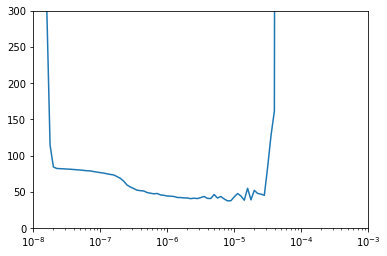

In [11]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
lr_best = lrs[np.argmin(history.history["loss"])]

In [12]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

#optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_best, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500)

Epoch 1/500
31/31 [==============================] - 0s 1ms/step - loss: 1183.5563
Epoch 2/500
31/31 [==============================] - 0s 732us/step - loss: 104.7844
Epoch 3/500
31/31 [==============================] - 0s 726us/step - loss: 74.4003
Epoch 4/500
31/31 [==============================] - 0s 712us/step - loss: 65.9888
Epoch 5/500
31/31 [==============================] - 0s 729us/step - loss: 61.1787
Epoch 6/500
31/31 [==============================] - 0s 700us/step - loss: 55.0841
Epoch 7/500
31/31 [==============================] - 0s 740us/step - loss: 51.1163
Epoch 8/500
31/31 [==============================] - 0s 746us/step - loss: 51.7548
Epoch 9/500
31/31 [==============================] - 0s 722us/step - loss: 46.0980
Epoch 10/500
31/31 [==============================] - 0s 1ms/step - loss: 46.3315
Epoch 11/500
31/31 [==============================] - 0s 785us/step - loss: 51.9018
Epoch 12/500
31/31 [==============================] - 0s 748us/step - loss: 49.2262
Ep

31/31 [==============================] - 0s 2ms/step - loss: 32.9468
Epoch 100/500
31/31 [==============================] - 0s 2ms/step - loss: 38.8904
Epoch 101/500
31/31 [==============================] - 0s 1ms/step - loss: 43.0097
Epoch 102/500
31/31 [==============================] - 0s 2ms/step - loss: 36.9486
Epoch 103/500
31/31 [==============================] - 0s 2ms/step - loss: 39.9428
Epoch 104/500
31/31 [==============================] - 0s 3ms/step - loss: 43.2626
Epoch 105/500
31/31 [==============================] - 0s 2ms/step - loss: 33.9881
Epoch 106/500
31/31 [==============================] - 0s 1ms/step - loss: 35.3946
Epoch 107/500
31/31 [==============================] - 0s 1ms/step - loss: 36.3104
Epoch 108/500
31/31 [==============================] - 0s 1ms/step - loss: 33.5427
Epoch 109/500
31/31 [==============================] - 0s 1ms/step - loss: 38.0122
Epoch 110/500
31/31 [==============================] - 0s 1ms/step - loss: 38.9973
Epoch 111/500
31/3

31/31 [==============================] - 0s 1ms/step - loss: 36.8827
Epoch 197/500
31/31 [==============================] - 0s 1ms/step - loss: 36.0008
Epoch 198/500
31/31 [==============================] - 0s 948us/step - loss: 42.9589
Epoch 199/500
31/31 [==============================] - 0s 766us/step - loss: 36.2392
Epoch 200/500
31/31 [==============================] - 0s 762us/step - loss: 35.8477
Epoch 201/500
31/31 [==============================] - 0s 773us/step - loss: 36.5526
Epoch 202/500
31/31 [==============================] - 0s 719us/step - loss: 37.9062
Epoch 203/500
31/31 [==============================] - 0s 698us/step - loss: 38.1264
Epoch 204/500
31/31 [==============================] - 0s 800us/step - loss: 35.7989
Epoch 205/500
31/31 [==============================] - 0s 1ms/step - loss: 33.3705
Epoch 206/500
31/31 [==============================] - 0s 1ms/step - loss: 33.6249
Epoch 207/500
31/31 [==============================] - 0s 1ms/step - loss: 33.8801
Epoc

31/31 [==============================] - 0s 767us/step - loss: 33.3013
Epoch 294/500
31/31 [==============================] - 0s 790us/step - loss: 41.4385
Epoch 295/500
31/31 [==============================] - 0s 693us/step - loss: 34.6713
Epoch 296/500
31/31 [==============================] - 0s 751us/step - loss: 33.5862
Epoch 297/500
31/31 [==============================] - 0s 1ms/step - loss: 37.1241
Epoch 298/500
31/31 [==============================] - 0s 990us/step - loss: 34.1105
Epoch 299/500
31/31 [==============================] - 0s 974us/step - loss: 37.5242
Epoch 300/500
31/31 [==============================] - 0s 880us/step - loss: 32.5739
Epoch 301/500
31/31 [==============================] - 0s 752us/step - loss: 41.0323
Epoch 302/500
31/31 [==============================] - 0s 751us/step - loss: 37.1287
Epoch 303/500
31/31 [==============================] - 0s 780us/step - loss: 32.5866
Epoch 304/500
31/31 [==============================] - 0s 810us/step - loss: 35.0

31/31 [==============================] - 0s 924us/step - loss: 42.5352
Epoch 391/500
31/31 [==============================] - 0s 944us/step - loss: 36.4962
Epoch 392/500
31/31 [==============================] - 0s 945us/step - loss: 36.2211
Epoch 393/500
31/31 [==============================] - 0s 924us/step - loss: 35.0722
Epoch 394/500
31/31 [==============================] - 0s 1ms/step - loss: 39.4003
Epoch 395/500
31/31 [==============================] - 0s 977us/step - loss: 37.1957
Epoch 396/500
31/31 [==============================] - 0s 1ms/step - loss: 33.8841
Epoch 397/500
31/31 [==============================] - 0s 715us/step - loss: 31.2793
Epoch 398/500
31/31 [==============================] - 0s 765us/step - loss: 32.0246
Epoch 399/500
31/31 [==============================] - 0s 694us/step - loss: 31.4749
Epoch 400/500
31/31 [==============================] - 0s 758us/step - loss: 34.1142
Epoch 401/500
31/31 [==============================] - 0s 690us/step - loss: 33.924

31/31 [==============================] - 0s 755us/step - loss: 35.1092
Epoch 488/500
31/31 [==============================] - 0s 787us/step - loss: 31.7373
Epoch 489/500
31/31 [==============================] - 0s 800us/step - loss: 30.8537
Epoch 490/500
31/31 [==============================] - 0s 717us/step - loss: 33.0549
Epoch 491/500
31/31 [==============================] - 0s 792us/step - loss: 32.2388
Epoch 492/500
31/31 [==============================] - 0s 780us/step - loss: 32.3067
Epoch 493/500
31/31 [==============================] - 0s 727us/step - loss: 31.4868
Epoch 494/500
31/31 [==============================] - 0s 764us/step - loss: 35.2598
Epoch 495/500
31/31 [==============================] - 0s 776us/step - loss: 35.3697
Epoch 496/500
31/31 [==============================] - 0s 716us/step - loss: 41.0206
Epoch 497/500
31/31 [==============================] - 0s 806us/step - loss: 37.3372
Epoch 498/500
31/31 [==============================] - 0s 919us/step - loss: 29

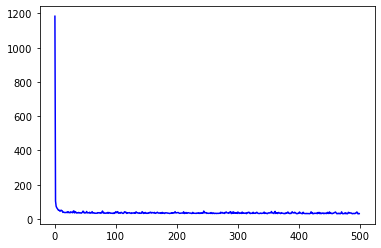

In [13]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[51.9018440246582, 49.2261848449707, 47.99470138549805, 38.77717590332031, 39.69768142700195, 39.18541717529297, 37.829856872558594, 37.976688385009766, 38.67255401611328, 38.161720275878906, 40.97068786621094, 37.30522537231445, 42.38626480102539, 37.18873596191406, 37.95754623413086, 36.4188117980957, 42.39095687866211, 38.89070510864258, 38.8012580871582, 36.62175750732422, 44.96147155761719, 47.844905853271484, 35.82871627807617, 43.27581024169922, 37.75086212158203, 38.876060485839844, 34.8618049621582, 36.4080810546875, 36.72175598144531, 38.24785232543945, 35.21745300292969, 36.43887710571289, 35.94246292114258, 33.93317794799805, 36.092594146728516, 39.2440185546875, 45.638519287109375, 44.03651428222656, 35.3781623840332, 36.084014892578125, 35.68136978149414, 37.084930419921875, 43.99968338012695, 35.774166107177734, 36.71001434326172, 36.77641296386719, 35.658409118652344, 39.369171142578125, 34.886932373046875, 34.41630935668945, 37.034915924072266, 42.94662094116211, 34.90

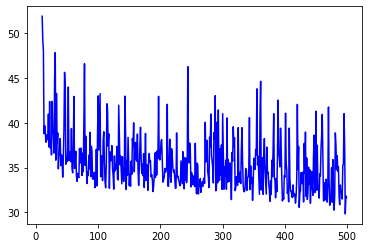

In [14]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

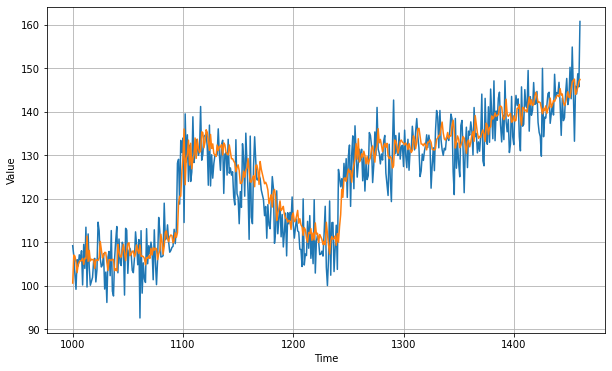

In [15]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis],verbose = 0))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.640593